In [1]:
# Importing necessary libraries
import pickle
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import  roc_curve


# VARS

In [2]:
MODEL_PATH = f"./records/"
uuid_global = "d93eb694-df50-4604-a044-525058f0934c"
uuid_local = "69896b8a-3774-47c2-b35e-75e5c7a4071b"

# Train/Val Metrics - Único

## LOCAL

Text(0.5, 1.0, 'Train/Val Loss x Epochs - Local')

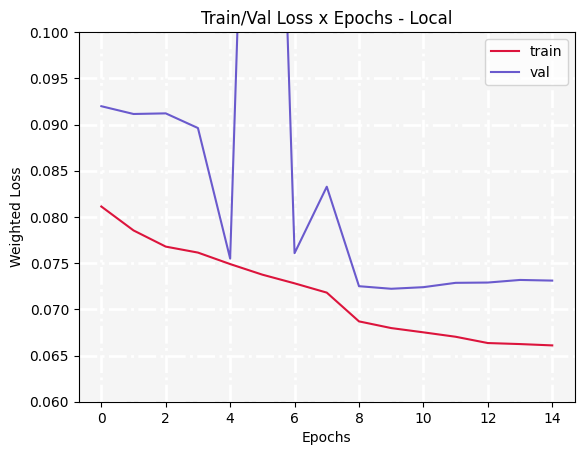

In [8]:
with open(f"{MODEL_PATH}/{uuid_local}/history_local", "rb") as f:
    h = pickle.load(f)
plt.xlabel("Epochs")
plt.ylabel("Weighted Loss")
plt.gca().set_facecolor("whitesmoke")
plt.grid(color='w', linewidth=2, linestyle='-.')
plt.plot(h['loss'], c='crimson')
plt.plot(h['val_loss'], c='slateblue')
plt.legend(['train', 'val'])
plt.ylim(0.06, 0.1)  # Define o intervalo de 0,1 a 0,9 no eixo y

plt.title("Train/Val Loss x Epochs - Local")

## GLOBAL

Text(0.5, 1.0, 'Train/Val Loss x Epochs - Global')

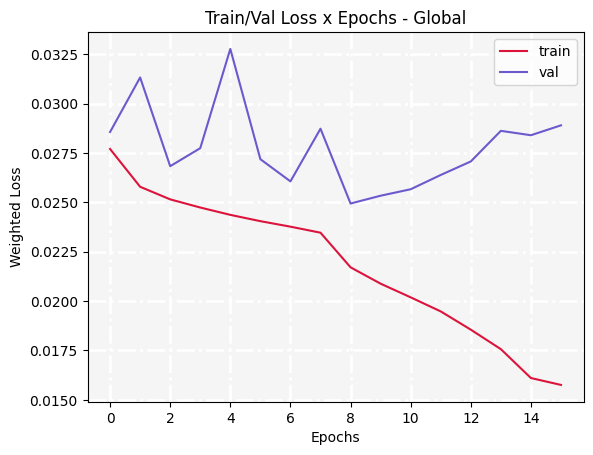

In [4]:
with open(f"{MODEL_PATH}/{uuid_global}/history_global", "rb") as f:
    h = pickle.load(f)
plt.xlabel("Epochs")
plt.ylabel("Weighted Loss")
plt.gca().set_facecolor("whitesmoke")
plt.grid(color='w', linewidth=2, linestyle='-.')
plt.plot(h['loss'], c='crimson')
plt.plot(h['val_loss'], c='slateblue')
plt.legend(['train', 'val'])
# plt.ylim(0.06, 0.12)  # Define o intervalo de 0,1 a 0,9 no eixo y

plt.title("Train/Val Loss x Epochs - Global")

# ROC

In [5]:
def plot_roc_curve(uuid ,metrics, title):
    with open(f"{MODEL_PATH}/{uuid}/{metrics}", "rb") as f:
        var = pickle.load(f)
    # Calculando a curva AUC
    plt.figure(figsize=(10, 8))
    # Plotando as curvas ROC
    for i in range(len(var['labels'])):
        fpr, tpr, _ = roc_curve(var['groun_truth'][:, i], var['predictions'][:, i])
        plt.plot(fpr, tpr, label=var['labels'][i] + ' (AUC = {:.2f})'.format(var['auc_scores'][i]))
    print(f"Auc-Macro = {var['auc_macro']}")
    print(f"Auc-Micro = {var['auc_micro']}")
    print(f"Auc-Weighted = {var['auc_weighted']}")
    # Adicionando legendas e título ao gráfico
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivos')
    plt.title(f'Curva ROC para cada classe: {title}')
    plt.legend()

    # Exibindo o gráfico
    plt.show()

Auc-Macro = 0.7498577726670742
Auc-Micro = 0.8382967529710517
Auc-Weighted = 0.7341273749159632


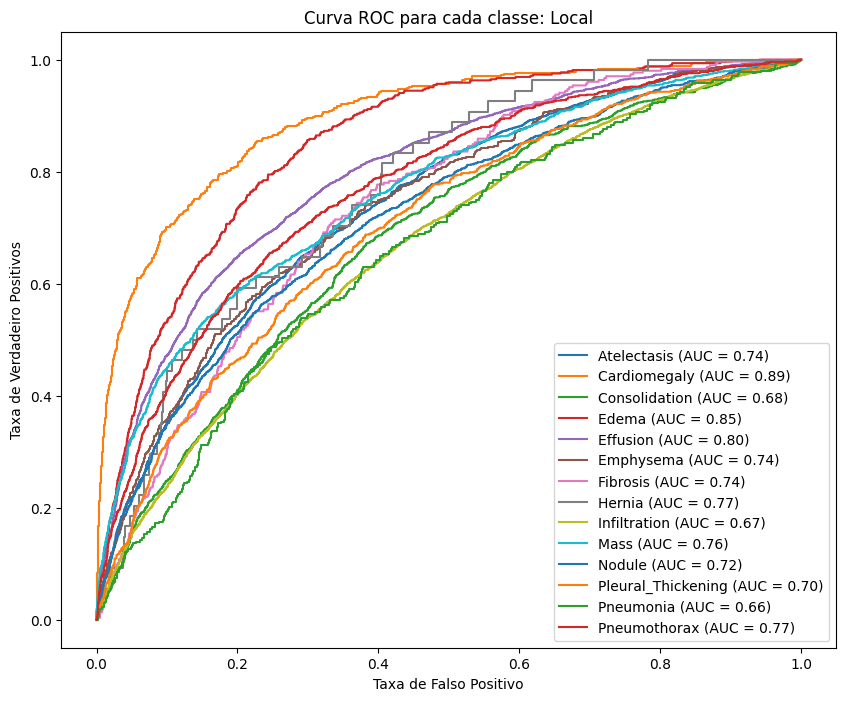

In [13]:
plot_roc_curve(uuid_local,"metrics_local", "Local")

Auc-Macro = 0.8108468619747855
Auc-Micro = 0.8714791288772206
Auc-Weighted = 0.7864883395168056


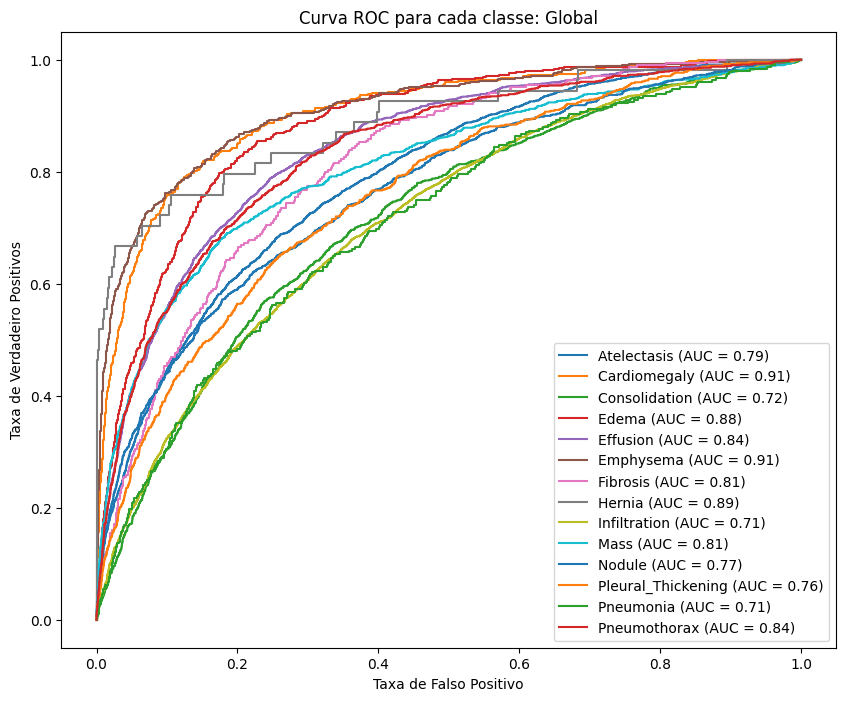

In [6]:
plot_roc_curve(uuid_global,"metrics_global", "Global")

# Train/Val Metrics - Paralelo

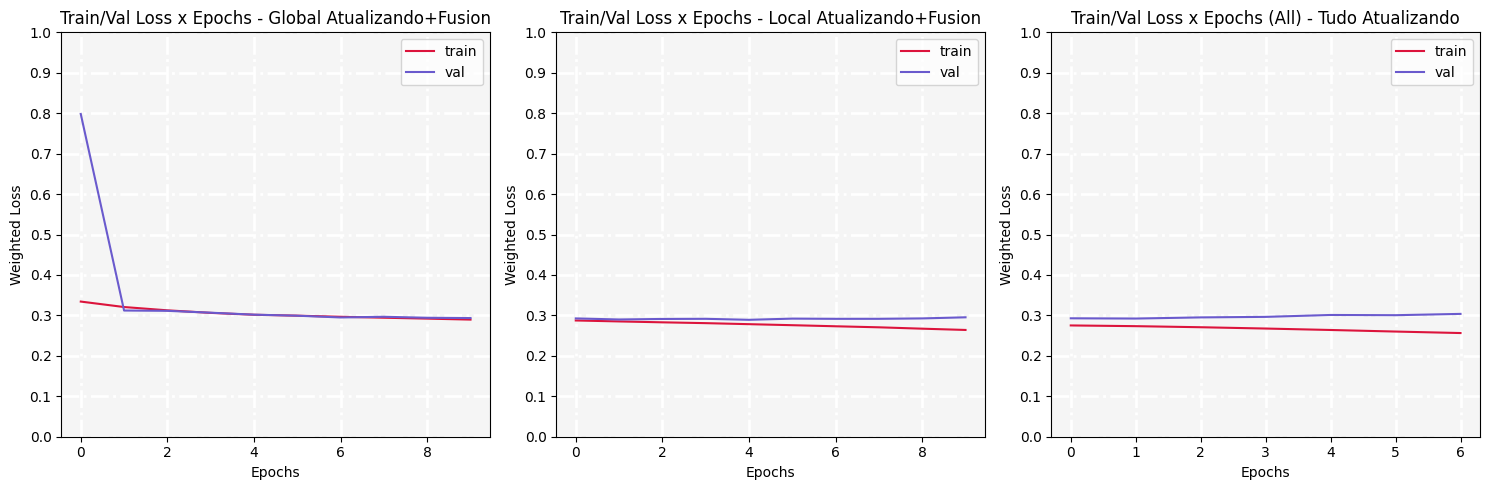

In [19]:
# Loading the first history data
with open(f"{MODEL_PATH}/history_all", "rb") as f:
    h_all = pickle.load(f)

# Loading the other two history data (replace "history_1" and "history_2" with the actual filenames)
with open(f"{MODEL_PATH}/history_global", "rb") as f:
    h_1 = pickle.load(f)

with open(f"{MODEL_PATH}/history_local", "rb") as f:
    h_2 = pickle.load(f)

# Creating subplots for side-by-side comparison
plt.figure(figsize=(15, 5))  # Adjust the figure size as needed


# Second subplot
plt.subplot(1, 3, 1)
plt.xlabel("Epochs")
plt.ylabel("Weighted Loss")
plt.gca().set_facecolor("whitesmoke")
plt.grid(color='w', linewidth=2, linestyle='-.')
plt.plot(h_1['loss'], c='crimson')
plt.plot(h_1['val_loss'], c='slateblue')
plt.legend(['train', 'val'])
plt.gca().set_ylim(0, 1)
plt.gca().set_yticks([i/10 for i in range(11)])
plt.title("Train/Val Loss x Epochs - Global Atualizando+Fusion")

# Third subplot
plt.subplot(1, 3, 2)
plt.xlabel("Epochs")
plt.ylabel("Weighted Loss")
plt.gca().set_facecolor("whitesmoke")
plt.grid(color='w', linewidth=2, linestyle='-.')
plt.plot(h_2['loss'], c='crimson')
plt.plot(h_2['val_loss'], c='slateblue')
plt.legend(['train', 'val'])
plt.gca().set_ylim(0, 1)
plt.gca().set_yticks([i/10 for i in range(11)])
plt.title("Train/Val Loss x Epochs - Local Atualizando+Fusion")

# First subplot
plt.subplot(1, 3, 3)
plt.xlabel("Epochs")
plt.ylabel("Weighted Loss")
plt.gca().set_facecolor("whitesmoke")
plt.grid(color='w', linewidth=2, linestyle='-.')
plt.plot(h_all['loss'], c='crimson')
plt.plot(h_all['val_loss'], c='slateblue')
plt.legend(['train', 'val'])
plt.gca().set_ylim(0, 1)
plt.gca().set_yticks([i/10 for i in range(11)])
plt.title("Train/Val Loss x Epochs (All) - Tudo Atualizando")

plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.show()
